In [1]:
include("main.jl");

## A rough guide to simulating split Lagrangian PDMP 

### Introduction to the analytical side of PDMP methods
In what follows we attempt to connect the theory discussed in [the associated paper](https://arxiv.org/abs/2509.24847) to the running and implementing code for this project. To illustrate how the code is intended to be used, we show how a user may use the code with minimal resp. maximal amounts of user-specified input. Throughout this introductory document we use the suffix '_alice' for a user that uses the defaults and '_bob' for a user that specifies (almost) every possible entry. 

First we discuss PDMP methods. Then we mention briefly how targets are implemented. Taken together these define a specific PDMP (though 'PDMP' and 'PDMP method' are used interchangeably in places it is appropriate to separate them conceptually). We include show how to set some numerical parameters, and then how to use the main code to draw samples.

#### Sampling using Metropolis-corrected PDMP methods
The main goal of the project is to sample a distribution $\pi$ using PDMP methods. Each PDMP method defines its own sampler, but structurally their inner workings a mostly similar: Generate a point, compute the acceptance probability of the point, accept or reject the point and repeat the process for a number of steps $N$. Here "points" refers to position-velocity pairs $(x,v)$ whereas in the final sampler we are interested only in the positions $x$.

#### The PDMP methods we have considered
There are countless possible PDMP methods to implement. In this project we have implemented three; BPS, SL-BPS and CA-BPS.
Since the names for the latter two were developed after the algorithms, they have internal names that do not match these names. 
The correspondence is

1) CA-BPS = Version 6.2
2) SL-BPS = Lagrangian

These two methods are implemented using explicitly and exclusively the soft absolute metric, though other choices could have been made.
The soft absolute metric is parametrized by the hardness $\alpha$ and so both PDMPs have a parameter (hardness) as part of their structure.
Unless otherwise specified, the hardness defaults to $\alpha = 0.5$.

Associated to each PDMP method is a structure.  

In [2]:
sl_bps = Lagrangian() 
ca_bps = Version6_2() 
bps = BPS() 

#For later comparison we define 
method_alice = Version6_2()
method_bob = Version6_2(0.41)

Version6_2(0.41)

#### The target distribution
It is practical to use the log-density of the target distribution $\pi$ in computation. Together with the dimension this constitutes the "target data". 
A user may specify more or less any target, but should note that performance of the code is very sensitive to a good (allocation free) implementation of the log target.

In [3]:
#A mean 0 unimodal multivariate normal distribution as target 
my_log_density = X-> -(dot(X,X)/2 + 100*pi)

#Since we must be able to infer the dimension of an input target, we must specify it
my_dim = 100

my_target = TargetData(my_log_density, my_dim)

TargetData{var"#42#43"}(var"#42#43"(), 100)

For a more interesting working example, let us consider the "Twin Peaks" target: A bimodal sum of Gaussians (for both Alice and Bob) in two dimensions.

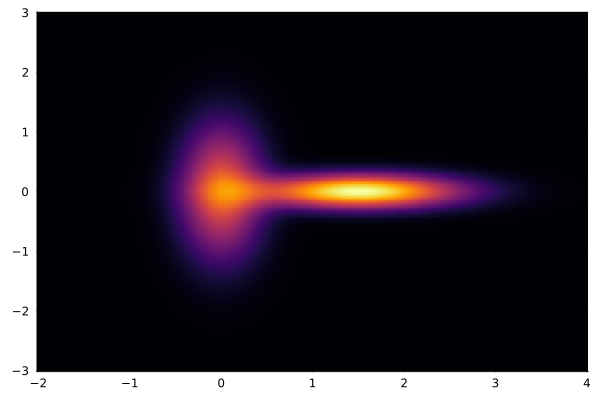

In [4]:
include("Test targets/Twin peaks.jl")
twin_peaks_target = TargetData(twin_peaks, 2)

#The target density
plt = visualize_2D_density(twin_peaks_target.log_density, heat = true, xs = range(-2,4,200), ys = range(-3,3,200))
plot(plt)

Having specified the target and the PDMP method Alice and Bob now have their actual PDMPs:

In [5]:
pdmp_alice = PDMP(method = method_alice, target = twin_peaks_target)
pdmp_bob = PDMP(method = method_bob, target = twin_peaks_target)

PDMP{Version6_2}(Version6_2(0.41), TargetData{typeof(twin_peaks)}(Main.twin_peaks, 2), false)

To summarize, the above data is precisely what is needed to run an actual simulation "on paper". In our implementation some further numerical parameters and methods are also necessary to prescribe.

### Numerical parameters of the PDMPs 
Each of the above PDMPs has to compute certain quantities to produce transition rates and flows. The computational methods that are used to derive these quantities are defined in the respect numerical parameters. Let us consider the case of CA-BPS and just say that SL-BPS follows a completely analogous pattern.

For CA-BPS we have three fields in the numerical parameters structure:

1) The 'position_method'
2) The 'auxiliary_method'
3) The 'diff_method'

#### The 'position_method'
The position method refers to the method by which positions $x$ along the flow are computed and rates $\lambda(x,v,0)$ are approximated. 

In practice, we set a step size to some $h$ and let $x_{n+1} = x_n + vh$. However, we have two choices for the stepsize

1) Piecewise constant method, fixing $h$ to some constant.
2) Adaptive piecewise constant, letting the step size $h$ vary to account for large changes in the rate $\lambda(x,v,0)$. This uses a tolerance $tol$, a default step size and a maximal multiplier on the adaptive step size. Again some defaults are defined so that a user can use it without defining

The latter is generally preferrable to use. Defaults to a piecewise constant method with stepsize $h = 0.01$.

#### The 'auxiliary_method'
An ODE-solver method. Defaults to a composite method suggested in the Julia "OrdinaryDiffEq" package. Determines how velocity-flows and rates $\lambda(x,v,1)$ are computed.

#### The 'diff_method'
Determines how derivatives are computed. Presently the default corresponds to using ForwardDiff, though the user in theory can provide their own analytical derivatives.

#### Specifying the numerics
Below we illustrate how Alice and Bob can specify their numerics

In [ ]:
#Alice uses the default numerics specific to the CA-BPS PDMP, i.e. the PDMP with internal name 'Version6_2':
numerics_alice = Version6_2Numerics()

#Bob specifies that the position rate approximations should be done using an adaptive method
step = 0.02
tolerance = 0.03 
max_mult = 120
pos_metod = VTAdaptivePiecewiseConstant(tolerance, step, max_mult)

#Bob uses a different solver than the default
aux_method = Stepanov5()

#Bob could compute the derivatives by hand and implement them as in-place functions, roughly as
#diff_method = AnalyticalDer(gradient!, hessian!, third_order_directional!, third_order_full!)
#Alternatively (but inadvisably), this could be used as a hacky way to use other methods than ForwardDiff
#Bob uses the (default) ForwardDiff AD method since the Twin Peaks target is not so easily differentiated.
diff_method = ForwardDer()

#The full numerical parameters for the PDMP are now summarized in a method. 
numerics_bob = Version6_2Numerics(pos_metod, aux_method, diff_method)

Version6_2Numerics(VTAdaptivePiecewiseConstant(0.03, 0.02, 120.0), Stepanov5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false)), ForwardDer())

### Parameters of the full Metropolis adjusted algorithm

To generate a set of positions $X$ we can at this point run the algorithm. However, there is still a small set of parameters to define.

1) The time $T$ for which we run the PDMP before suggesting a point for acceptance/rejection. Defaults to $1.0$.
2) The number of points $N$ we are interested in generating before we stop iterating. Defaults to $10$.
3) The initial state $(x,v)$ at which we start our first iteration.

#### The time $T$
In practice this parameter impacts the efficiency of sampling, and the optimal choice depends on the PDMP considered.

#### The number of points $N$
Self explanatory, but should be set to a small value in initial tests as the computation time for excessive values of $N$ can be very large.

#### The initial state
Effectively our choice of $(x,v)$ to start the iteration from. $x$ defaults to a random value according to $x \sim \mathcal{N}(0,1)$ and by default $v|x \sim \mathcal{N}(0, G^{-1}(x))$.

In [7]:
T_bob = 1.1

#In any particular use case a specific N is often 'predefined'.
#For a somewhat fair comparison, let Alice and Bob have the same N.
N = 400

#Alice is happy to use the initial state defined above. Bob however wants to start at a specific point (x,v).
initial_state_bob = BinaryState([1/42, 0.8], [0.1^42, sqrt(pi)])

BinaryState([0.023809523809523808, 0.8], [1.0000000000000023e-42, 1.7724538509055159])

### Running the algorithm
From here Alice and Bob can run the algorithm. In its current implementation it outputs three things:
1) An array of all accepted points $(x,v)$
2) An array of acceptances for the points
3) A number indicating the number of events that occurred in the simulation

In [8]:
output_alice = algorithm(pdmp_alice, numerics_alice, point_number = N)
output_bob = algorithm(pdmp_bob, numerics_bob, point_number = N, max_time = T_bob, initial_state = initial_state_bob)

(BinaryState[BinaryState([0.023809523809523808, 0.8], [1.0000000000000023e-42, 1.7724538509055159]), BinaryState([-0.22631181294535502, 0.53703098655113], [-0.14353129140004975, -0.49435109605842503]), BinaryState([0.2240574324709435, 0.6436703348509784], [0.1114777258481155, 0.93279213842663]), BinaryState([0.2240574324709435, 0.6436703348509784], [0.1114777258481155, 0.93279213842663]), BinaryState([0.2240574324709435, 0.6436703348509784], [0.1114777258481155, 0.93279213842663]), BinaryState([-0.11645103067418491, 1.1532276256967184], [-0.3095531483137531, 0.4632339007688547]), BinaryState([-0.26107287688593217, 0.5746749232297383], [-0.1314744056470429, -0.525957002242709]), BinaryState([-0.26107287688593217, 0.5746749232297383], [-0.1314744056470429, -0.525957002242709]), BinaryState([-0.26107287688593217, 0.5746749232297383], [-0.1314744056470429, -0.525957002242709]), BinaryState([-0.44182101170547416, 0.3939360487901761], [0.5719366172232021, -0.5928708669829155])  …  BinaryStat

We can access the accepted positions $x$ in the following way:

In [9]:
#The array of of pairs (x,v):
states_alice = output_alice[1] 
#In the BinaryState structure we have two fields: "Position" (x) and "auxiliary" (v)
#The positions can thus be collected by taking
points_alice = [states_alice[i].position for i in eachindex(states_alice)];

We can now see how e.g. acceptances were affected by the choices of parameters. Of course the algorithm is stochastic, so results may vary unless we specify a seed.

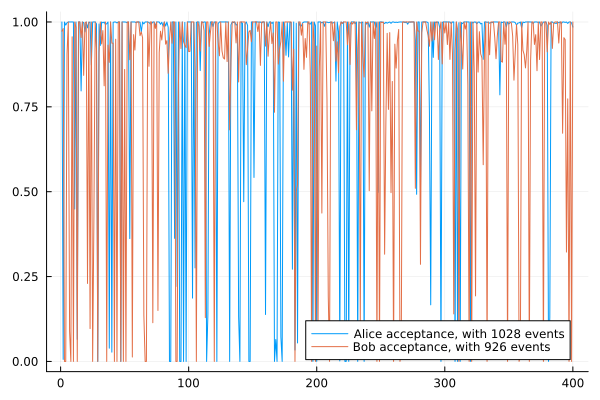

In [10]:
plt_acc_alice = plot(output_alice[2], label = "Alice acceptance, with $(output_alice[3]) events")
plot!(output_bob[2], label = "Bob acceptance, with $(output_bob[3]) events")

Generally these plots are not very interesting without rolling averages or similar processing. Of course we're generally far more interested in the values $x$ that we sample. For the purpose of illustrating the algorithm here we have implemented a simple function in plotting.jl.

### A visualization of 2D target "Twin Peaks"
We run a specialized function 'plot_algorithm_run' (which should work on any 2D target) with appropriate parameters to display our Twin Peaks sampling

Number of unique points: 340
Number of unique points: 298


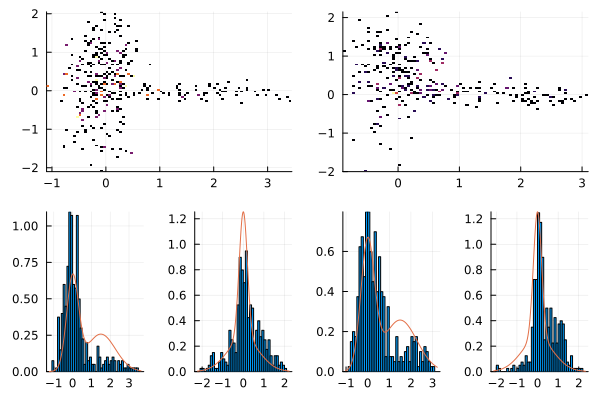

In [12]:
#We specify the marginal distributions for the Twin Peaks target
x_marginal = x_marginal_distr
y_marginal = y_marginal_distr

#In its current implementation the visualization function requires us to specify an inital state
initial_state_alice = BinaryState([0.0, 0.0], [0.0, 0.0]) 

plt_alice = plot_algorithm_run(pdmp_alice, x_marginal, y_marginal, initial_state_alice, numerics_alice, point_number = N)
plt_bob = plot_algorithm_run(pdmp_alice, x_marginal, y_marginal, initial_state_bob, numerics_bob, point_number = N, max_time = T_bob)
plt = plot(plt_alice, plt_bob, layout = @layout[a b])

The choice of $N = 400$ is generally far too small to reasonably reslove the target. Using Alice's numerics and pushing $N$ higher we get a better picture. Because the current implementation is somewhat slow we advise caution in scaling $N$ and $T$ to extremely high values, but here a ten-fold increase is generally not too slow:

Number of unique points: 3515


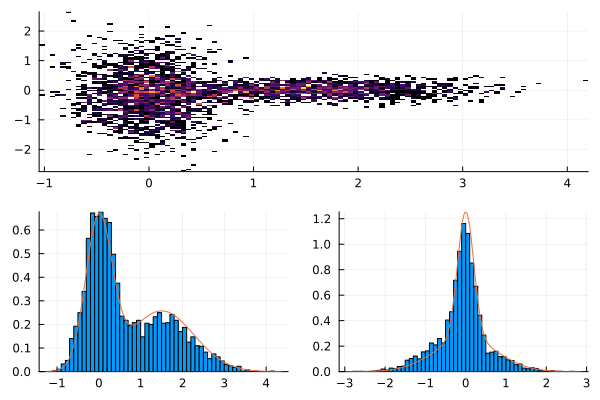

In [16]:
plt_alice_long_and_slow = plot_algorithm_run(pdmp_alice, x_marginal, y_marginal, initial_state_alice, numerics_alice, point_number = 4000)